In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils import load_mnist
from trainer import Trainer

In [4]:
from argparse import Namespace

config = {
  'train_ratio': .8,
  'batch_size' : 8,
  'n_epochs' : 10,
  'verbose' : 1,
  'btl_size' : 2,
}

config = Namespace(**config)

print(config)

Namespace(train_ratio=0.8, batch_size=8, n_epochs=10, verbose=1, btl_size=2)


In [6]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
  train_x,
  dim = 0,
  index = indices
).split([train_cnt, valid_cnt], dim = 0)
train_y, valid_y = torch.index_select(
  train_y,
  dim = 0,
  index = indices
).split([train_cnt, valid_cnt], dim = 0)

print("Train: ", train_x.shape, train_y.shape)
print("Valid: ", valid_x.shape, valid_y.shape)
print("Test: ", test_x.shape, test_y.shape)

Train:  torch.Size([48000, 784]) torch.Size([48000])
Valid:  torch.Size([12000, 784]) torch.Size([12000])
Test:  torch.Size([10000, 784]) torch.Size([10000])


In [7]:
from model import Autoencoder

In [8]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [9]:
# autoencoder 복원을 확인하는 것이므로 _y는 필요없음
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/10: train_loss=0.0639)  valid_loss=0.0564  lowest_loss=0.0564
Epoch(2/10: train_loss=0.0554)  valid_loss=0.0550  lowest_loss=0.0550
Epoch(3/10: train_loss=0.0546)  valid_loss=0.0547  lowest_loss=0.0547
Epoch(4/10: train_loss=0.0542)  valid_loss=0.0566  lowest_loss=0.0547
Epoch(5/10: train_loss=0.0539)  valid_loss=0.0560  lowest_loss=0.0547
Epoch(6/10: train_loss=0.0540)  valid_loss=0.0552  lowest_loss=0.0547
Epoch(7/10: train_loss=0.0523)  valid_loss=0.0557  lowest_loss=0.0547
Epoch(8/10: train_loss=0.0524)  valid_loss=0.0554  lowest_loss=0.0547
Epoch(9/10: train_loss=0.0522)  valid_loss=0.0558  lowest_loss=0.0547
Epoch(10/10: train_loss=0.0522)  valid_loss=0.0580  lowest_loss=0.0547


In [ ]:
def show_image(x):
  if x.dim() == 1:
    x = x.view(int(x.size(0) ** .5), -1)
  
  plt.imshow(x, cmap='gray')
  plt.show()

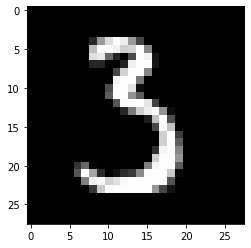

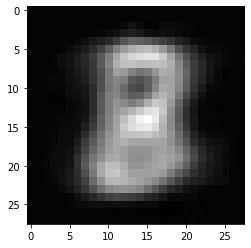

In [18]:
with torch.no_grad():
  import random

  index = int(random.random() * test_x.size(0))

  recon = model(test_x[index].view(1, -1)).squeeze()

  show_image(test_x[index])
  show_image(recon)

# Latent space

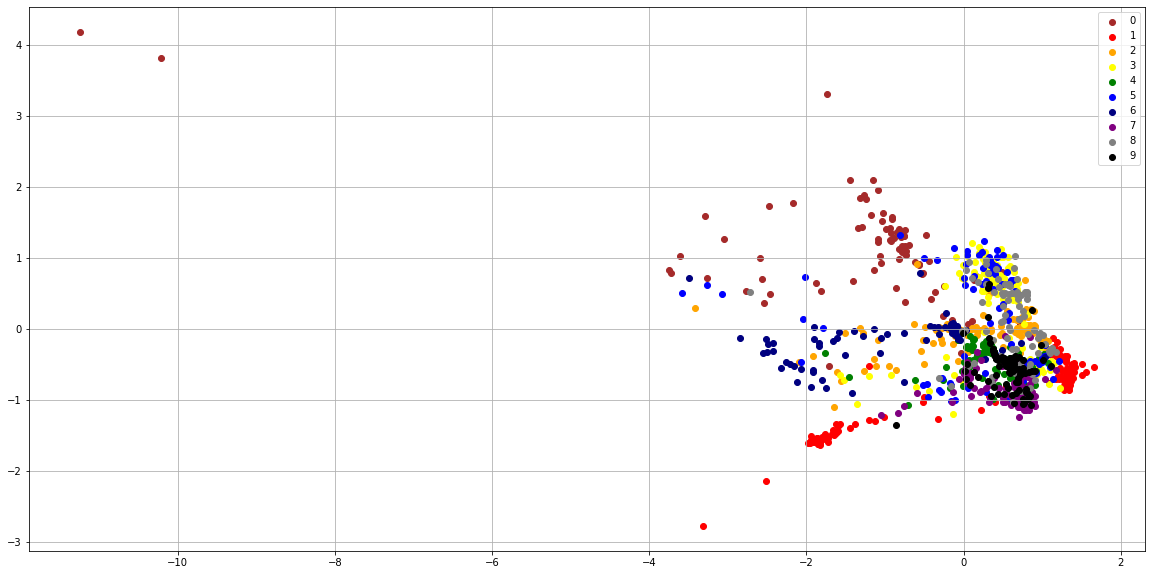

In [20]:
if config.btl_size == 2:
  color_map = [
    'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'navy', 'purple', 'gray', 'black',
  ]

  plt.figure(figsize=(20, 10))
  with torch.no_grad():
    latents = model.encoder(test_x[:1000])

    for i in range(10):
      target_latents = latents[test_y[:1000] == i]
      target_y = test_y[:1000][test_y[:1000] == i]
      plt.scatter(target_latents[:,0],
                  target_latents[:,1],
                  marker='o',
                  color=color_map[i],
                  label=i)
    
    plt.legend()
    plt.grid(axis='both')
    plt.show()

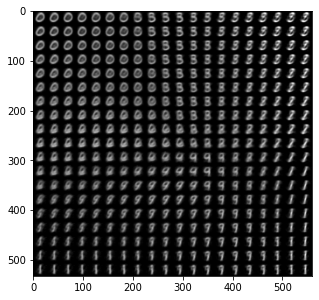

In [36]:
if config.btl_size == 2:
  min_range, max_range = -2., 2.
  n = 20
  step = (max_range - min_range) / float(n)

  with torch.no_grad():
    lines = []

    for v1 in np.arange(min_range, max_range, step):
      z = torch.stack([
        torch.FloatTensor([v1] * n),
        torch.FloatTensor([v2 for v2 in np.arange(min_range, max_range, step)]),
      ], dim=-1)
    
      line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
      line = torch.cat([line[i] for i in range(n-1, 0, -1)], dim=0)
      lines += [line]

    lines = torch.cat(lines, dim=-1)
    plt.figure(figsize=(5,5))
    show_image(lines)
